# An Example of Hard and Soft Voting
borrowed from [Aurelien Geron](https://github.com/ageron/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb).

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/phunc20/biblio/blob/main/people/aurelien_geron/homl/07-ensemble_learning/notebooks/04.16.agerons_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

In [ ]:
import sys

In [ ]:
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install matplotlib==3.6.1 numpy==1.23.1 \
         scikit-learn==1.1.2 scipy==1.9.0 tqdm==4.64.0

## Dataset

In [1]:
from sklearn.datasets import make_moons

In [2]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X.shape, y.shape

((500, 2), (500,))

In [3]:
import matplotlib.pyplot as plt

plt.style.use("dark_background")

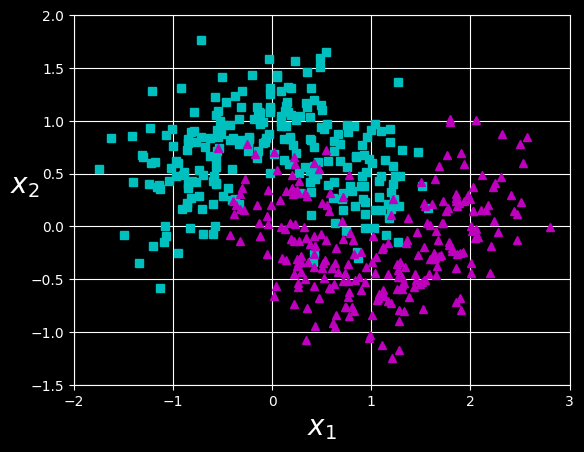

In [4]:
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "cs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "m^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-2, 3, -1.5, 2])
plt.show()

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.7,
    random_state=42,
)
X_train.shape, X_test.shape

((350, 2), (150, 2))

## Hard Voting

We need a bunch of different estimators/models.

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [8]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[("lr", log_clf), ("rf", rnd_clf), ("svc", svm_clf)],
    voting="hard",
)

Let's check out each classifier's accuracy on the test set.

In [9]:
from sklearn.metrics import accuracy_score

In [10]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"({clf.__class__.__name__}) {acc = :.4f}")

(LogisticRegression) acc = 0.8600
(RandomForestClassifier) acc = 0.9067
(SVC) acc = 0.9067
(VotingClassifier) acc = 0.9133


## Soft Voting

As we have seen in the slides, soft voting requires prediction probabilities from the classifiers.  
In other words, when it comes to using `VotingClassifier` in Scikit-Learn with `vote="soft"`, all of
the classifiers you feed into it should all have `predict_proba` methods.

This is not the case for `SVC`; that is, by default, `SVC` has this config arg `probability=False`.  
In order to equipe an `SVC` instance with `predict_proba` method, one needs
to set the arg to `True`.

**(?1)** How could we make sure that `SVC` really lacks `predict_proba` method by default?  
**(R1)** The following few code cells could be one way.

In [11]:
for clf in (log_clf, rnd_clf, svm_clf):
    print(f'"predict_proba" in dir({clf.__class__.__name__}) = {"predict_proba" in dir(clf)}')

"predict_proba" in dir(LogisticRegression) = True
"predict_proba" in dir(RandomForestClassifier) = True
"predict_proba" in dir(SVC) = True


So, checking this using `dir` does not work.

In [12]:
import traceback

In [13]:
for clf in (log_clf, rnd_clf, svm_clf):
    print(clf.__class__.__name__)
    try:
        clf.predict_proba(X_test)
    except:
        traceback.print_exc()
        print()

LogisticRegression
RandomForestClassifier
SVC



Traceback (most recent call last):
  File "/var/folders/l5/gygxbwc52h1br846nd2ml9b0cnzszn/T/ipykernel_92532/2347305104.py", line 4, in <cell line: 1>
    clf.predict_proba(X_test)
  File "/Users/wucf/.local/bin/miniconda3/envs/py3.10/lib/python3.10/site-packages/sklearn/utils/metaestimators.py", line 127, in __get__
    if not self.check(obj):
  File "/Users/wucf/.local/bin/miniconda3/envs/py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py", line 819, in _check_proba
    raise AttributeError(
AttributeError: predict_proba is not available when  probability=False


Ok, now let's train a soft `VotingClassifier`.

In [14]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[("lr", log_clf), ("rf", rnd_clf), ("svc", svm_clf)],
    voting="soft",
)

In [15]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"({clf.__class__.__name__}) {acc = :.4f}")

(LogisticRegression) acc = 0.8600
(RandomForestClassifier) acc = 0.9067
(SVC) acc = 0.9067
(VotingClassifier) acc = 0.9333


Note that in this particular example
- (Hard) `voting_clf` reaches `acc = 0.9133`
- (Soft) `voting_clf` reaches `acc = 0.9333`